In [17]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.datasets import mnist
from skimage import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import skimage.morphology as simo
from skimage import exposure
import skimage.filters as sif

def normalize_img(image, label):
    """Zamieniamy pixele z watrości 0 - 255 na wartości 0.0 - 1.0"""
    return tf.cast(image, tf.float32) / 255., label

def conf_matrix(model, classifier):
    (trainX, trainY), (testX, testY) = mnist.load_data()

    predictions = []

    for pred in model.predict(testX):
        predictions.append(np.argmax(pred))

    cm = confusion_matrix(testY, predictions)

    plt.figure(figsize=(10,5))
    axs = sns.heatmap(cm, annot=True, fmt='d', cmap='copper')
    axs.set_title('Macierz pomyłek dla {}'.format(classifier))
    axs.set_xlabel('Przypisane klasy')
    axs.set_ylabel('Wartości rzeczywiste')
    axs.set_xticklabels(range(0, 10))
    axs.set_yticklabels(range(0, 10))

def predict_nums(nums, model):
    for i in range(len(nums)):
        image = io.imread(f"{nums[i]}.png", as_gray=1)
        image_reshaped = image.reshape(-1, 28, 28, 1)

        prediction = model.predict(image_reshaped)

        plt.figure(figsize=(8,5))

        plt.subplot(1, 2, 1)
        plt.title(f"Prediction = {categories[np.argmax(prediction[0])]}", fontdict={"fontsize": 20})
        io.imshow(image)

        plotable = pd.DataFrame(prediction[0])

        plt.subplot(1, 2, 2)
        plt.tight_layout()
        plt.xticks(categories)
        plt.bar(categories, plotable[0])

        plt.show()

def accuracy_graph(history):
    plt.plot(history.history['sparse_categorical_accuracy'], label='accuracy')
    plt.plot(history.history['val_sparse_categorical_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1])
    plt.legend(loc='lower right')

### Sieć neuronowa

Sieć neuronowa pozwala nam na stworzenie i wyszkolenie modelu, który będzie się starał jak najlepiej przewidzieć kategorię dla danej wejściowej.

W naszym przypadku użyjemy sieci składającej się z 6 warstw:
1. Warstwa spłaszczająca - zamienia nam wielowymiarowe dane na jednowymiarową kolumnę.
2. Warstwa gęsta 512 neuronów - każdy neuron tej warstwy jest połączony z każdym poprzedniej. Poprzez operacje na macierzach obliczane są wartości neuronów w zależności od wartości poprzedniej warstwy.
3. Warstwa odrzucająca - zapobiega zbytniemu uczeniu się sieci pod dany zestaw testów.
4. Warstwa gęsta 128 neuronów
5. Warstwa odrzucająca
5. Warstwa gęsta 10 neuronów - finalna warstwa zawierająca tylko 10 neuronów, czyli tyle ile mamy kategorii. Jest to wyjście z naszego modelu. Im większa wartość neuronu tym pewniejsza jest sieć, że jest to ta kategoria.

##### Kroki tworzenia naszego modelu:
1. Ładujemy zestaw liczb z MINST dataset z podziałem na trening i testowanie
2. Przekształcamy wszystkie obrazy do skali szarości, czyli pixele reprezentowane jako wartości od 0.0 do 1.0
3. Mieszamy i dzielimy na zestawy dla generacji
4. Definiujemy warstwy sieci i tworzymy ją
5. Zaczynamy szkolenie na zestawie treningowym i do weryfikacji używamy testowego

Epoch 1/8
469/469 [==============================] - 4s 4ms/step - loss: 0.3480 - sparse_categorical_accuracy: 0.8959 - val_loss: 0.1407 - val_sparse_categorical_accuracy: 0.9570
Epoch 2/8
469/469 [==============================] - 2s 3ms/step - loss: 0.1518 - sparse_categorical_accuracy: 0.9542 - val_loss: 0.1029 - val_sparse_categorical_accuracy: 0.9688
Epoch 3/8
469/469 [==============================] - 2s 4ms/step - loss: 0.1137 - sparse_categorical_accuracy: 0.9652 - val_loss: 0.0871 - val_sparse_categorical_accuracy: 0.9730
Epoch 4/8
469/469 [==============================] - 2s 3ms/step - loss: 0.0917 - sparse_categorical_accuracy: 0.9710 - val_loss: 0.0842 - val_sparse_categorical_accuracy: 0.9736
Epoch 5/8
469/469 [==============================] - 2s 3ms/step - loss: 0.0791 - sparse_categorical_accuracy: 0.9743 - val_loss: 0.0778 - val_sparse_categorical_accuracy: 0.9751
Epoch 6/8
469/469 [==============================] - 2s 3ms/step - loss: 0.0676 - sparse_categorical_accu

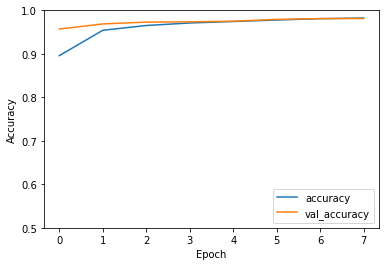

In [18]:
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

# num_parallel_calls - pozwala na szybsze wykonanie map poprzez równoległe mapowanie wielu elementów
ds_train = ds_train.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
# shuffle bierze buffer_size który ustawiamy na wielkość zbioru żeby na pewno było dobrze pomieszane
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
# dzielenie na części dla każdej generacji
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10)
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

history = model.fit(
    ds_train,
    epochs=8,
    validation_data=ds_test,
)

accuracy_graph(history)
# model.summary()

Wykres pokazuje zmianę dokładności na przestrzeni epok. Jak widać nawet po mniej niż 10 iteracjach przyrosty są znikome. Dlatego jeśli chcemy mieć bardzo dokładny model to niestety musimy poświęcić dużo czasu i zasobów komputera na szkolenie.

Po przeszkoleniu modelu możemy zacząć go używać do klasyfikacji naszych własnych danych.

Wczytujemy numery które sami napisaliśmy i przekształcamy do postaci akceptowanej przez model. Czyli zamieniamy ponownie wartości pixeli na skalę od 0 do 1 i jeśli trzeba to skalujemy do rozmiaru 28 na 28 pixeli.

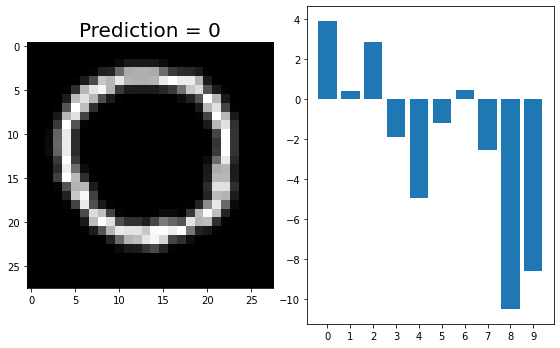

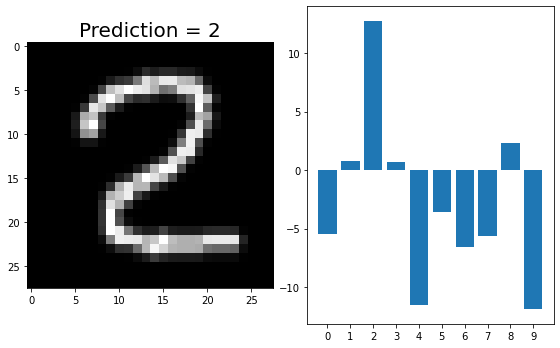

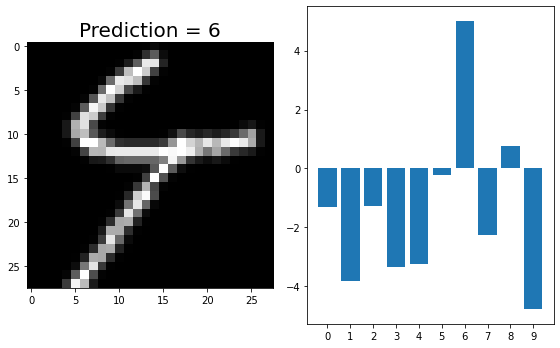

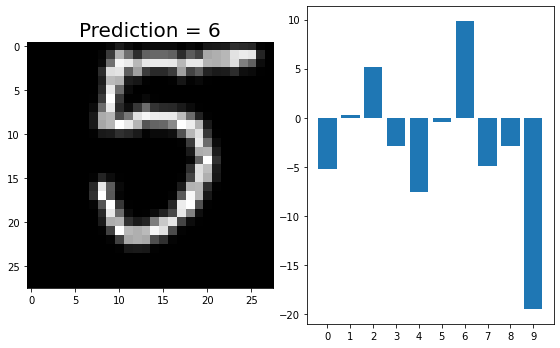

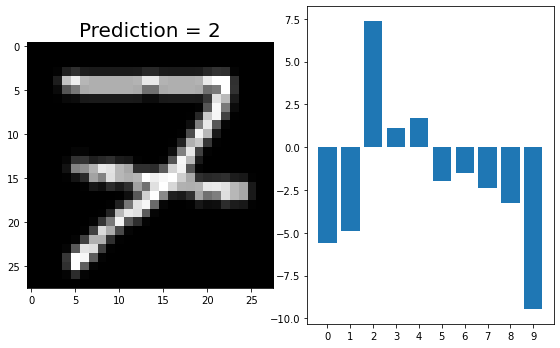

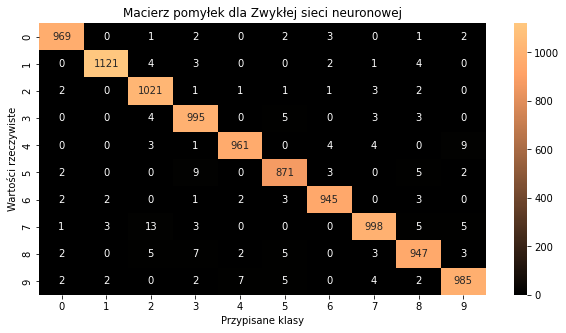

In [19]:
categories = range(0, 10)

our_nums = ["test_0", "test_2", "test_4", "test_5", "test_7"]

predict_nums(our_nums, model)

conf_matrix(model, "Zwykłej sieci neuronowej")

Jak widać model jest w stanie z dużą dokładnością stwierdzić jaki numer napisaliśmy. Ma on jednak problem z siódemką zapisaną z kreską i kategoryzuje ją często jako cztery albo dwa. Problemem też są niezgrabnie napisane liczby, w szczególności 5, 2, 4.

Po prawej stronie od liczby znajduje się wykres pewności czyli w zasadzie wartości ostatniej warstwy sieci. Im jest wyższa  tym większa szansa, że dany numer należy do danej kategorii.

Macierz pomyłek ukazuje nam, że w dobrze obrobionym zbiorze najbardziej mylone są 7 -> 2, 8 -> 3, 5 -> 4 i 9 -> 4.
Jak się nad tym zastanowić to ma to sens ponieważ rzeczywiście 7 i 2 mają podobny kształt a 8 to 3 z dwoma przerwami.

Model działa poprawnie jeżeli mamy dużą ilość epok w szkoleniu. Przy zmniejszaniu zaczyna się on mocno mylić.

#### Wnioski
- sieć neuronowa może w łatwy sposób poradzić sobie z zadaniem kategoryzacji numerów
- żeby model lepiej radził sobie z rozróżnianiem skrajnych przypadków i złego pisma należałoby stworzyć bardziej dokładne warstwy i potworzyć jakieś zależności ograniczenia między neuronami
- dla dobrze przerobionych obrazów (takich jak w MINST) model ma bardzo wysoką dokładność

## Sieć splotowa

Od poprzedniej różni się tym, że stosuje warstwy splotowe, które są specjalnie dostosowane do przyjmowania obrazów jako wejścia. Dużo lepiej radzi sobie z kategoryzowaniem obrazów.

Wejście do warstwy splotowej jest tensorem, w przeciwieństwie do jednowymiarowego wejścia w warstwie gęstej. Taka warstwa reaguje na dane w swoim polu receptywności i podaje dalej wyważone dane.

Warstwa puli służy do zmniejszania wymiarów danych łącząc je ze sobą.

Epoch 1/8
469/469 [==============================] - 17s 36ms/step - loss: 0.2404 - sparse_categorical_accuracy: 0.9281 - val_loss: 0.0731 - val_sparse_categorical_accuracy: 0.9768
Epoch 2/8
469/469 [==============================] - 17s 36ms/step - loss: 0.0624 - sparse_categorical_accuracy: 0.9808 - val_loss: 0.0447 - val_sparse_categorical_accuracy: 0.9865
Epoch 3/8
469/469 [==============================] - 18s 38ms/step - loss: 0.0421 - sparse_categorical_accuracy: 0.9869 - val_loss: 0.0322 - val_sparse_categorical_accuracy: 0.9892
Epoch 4/8
469/469 [==============================] - 17s 37ms/step - loss: 0.0322 - sparse_categorical_accuracy: 0.9898 - val_loss: 0.0331 - val_sparse_categorical_accuracy: 0.9896
Epoch 5/8
469/469 [==============================] - 17s 36ms/step - loss: 0.0275 - sparse_categorical_accuracy: 0.9915 - val_loss: 0.0280 - val_sparse_categorical_accuracy: 0.9911
Epoch 6/8
469/469 [==============================] - 17s 36ms/step - loss: 0.0221 - sparse_cate

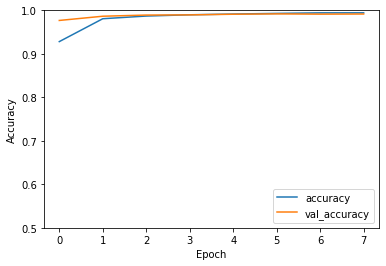

In [22]:
seq_model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (5, 5), activation="relu", input_shape=(28, 28, 1)),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Conv2D(64, (4, 4), activation="relu"),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10)
])

seq_model.compile(
  optimizer=tf.keras.optimizers.Adam(0.001),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

history = seq_model.fit(
  ds_train,
  epochs=8,
  validation_data=ds_test,
)

accuracy_graph(history)

Ponownie zobaczymy jak sobie radzi z naszymi liczbami.

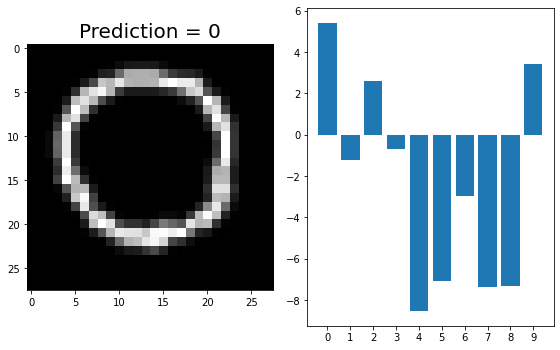

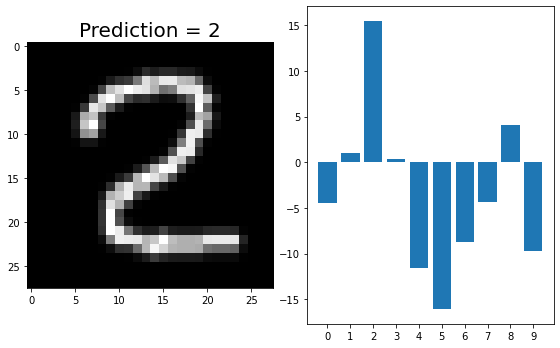

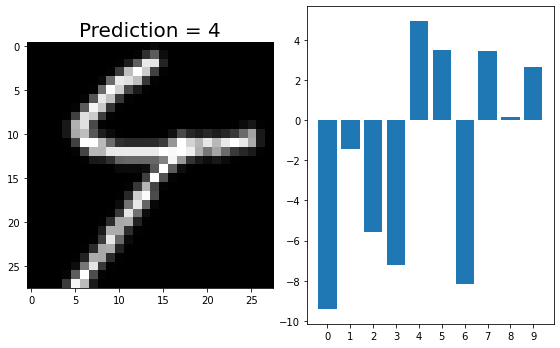

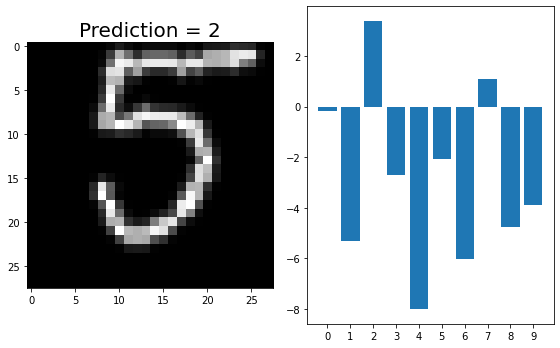

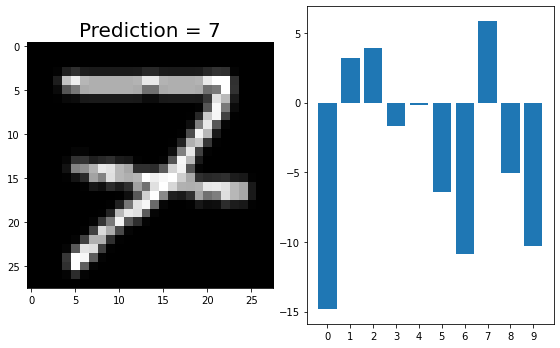

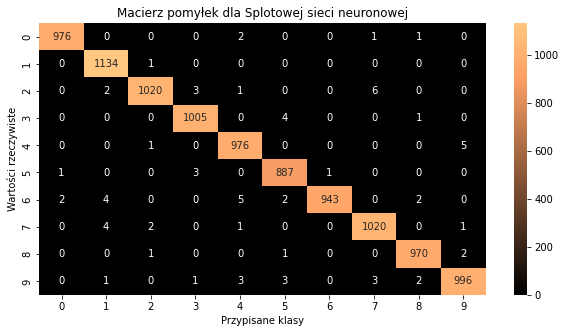

In [23]:
predict_nums(our_nums, seq_model)

conf_matrix(seq_model, "Splotowej sieci neuronowej")

Jak widać na macierzy pomyłek, nie mamy tu już typowych dla poprzedniej sieci błędów.
Zostały jednak zamienienia 2 -> 7, 4 -> 9, 6 -> 4, ale są one jednak dużo rzadsze.

W naszych numerach widać też trochę mniej błędów, ale jest to zależne od każdego szkolenia i zestaw danych jest za mały, żeby móc go uznać za miarodajny.

#### Wnioski
- szkolenie takiej sieci trwa o wiele dłużej
- sieć splotowa jest pewniejsza i trochę lepiej radzi sobie z przypadkami granicznymi
- teoretycznie jej dokładność jest bardzo wysoka, ale jak widać na przykładach nie z bazy MINST nie oznacza to że potrafi rozpoznać nasze obrazy poprawnie
- powodem błędnego kategoryzowania naszych przykładów, może być niedokładna obróbka i brak filtrowania obrazów

#### Źródła
- https://www.tutorialexample.com/understand-dense-layer-fully-connected-layer-in-neural-networks-deep-learning-tutorial/
- https://www.tensorflow.org/datasets/keras_example
- https://www.theprofessionalprogrammer.com/2018/11/neural-network-dense-layers.html
- https://iq.opengenus.org/dense-layer-in-tensorflow/
- https://machinelearningjourney.com/index.php/2021/01/09/adam-optimizer/
- https://iq.opengenus.org/relu-activation/
- https://pl.abcdef.wiki/wiki/Convolutional_neural_network